# Point to point low-thrust transfer

In [1]:
import pykep as pk
import numpy as np
import time
import pygmo as pg
import pygmo_plugins_nonfree as ppnf
import time

from matplotlib import pyplot as plt

In [2]:
class direct_point2point:
    """Represents a direct transcription of the optimal low-thrust transfer between two fixed points.

    This problem works using a Sims-Flanagan leg and manipulating its transfer time T, final mass mf and the controls.

    The decision vector is::

        z = [mf, throttles, tof]

    where throttles is a vector [u0x, u0y,u0z, ...]

    """

    def __init__(
        self,
        rvs=[
            np.array([1, 0.1, -0.1]) * pk.AU,
            np.array([0.2, 1, -0.2]) * pk.EARTH_VELOCITY,
        ],
        rvf=[
            np.array([-1.2, -0.1, 0.1]) * pk.AU,
            np.array([0.2, -1.023, 0.44]) * pk.EARTH_VELOCITY,
        ],
        ms=1000,
        mu=pk.MU_SUN,
        max_thrust=0.12,
        isp=3000,
        tof_bounds=[80, 400],
        mf_bounds=[200.0, 1000.0],
        nseg=10,
        cut=0.6,
        mass_scaling=1000,
        r_scaling=pk.AU,
        v_scaling=pk.EARTH_VELOCITY,
        with_gradient=True,
    ):
        # We add as data member one single Sims-Flanagan leg using the problem data
        # and some temporary (and unused, thus irrelelvant) values for the to-be-optimzed parameters throttles, tof and mf.
        throttles = np.random.uniform(-1, 1, size=(nseg * 3))
        self.leg = pk.leg.sims_flanagan(
            rvs=rvs,
            ms=ms,
            throttles=throttles,
            rvf=rvf,
            mf=np.mean(mf_bounds),
            tof=np.mean(tof_bounds) * pk.DAY2SEC,
            max_thrust=max_thrust,
            isp=isp,
            mu=mu,
            cut=cut,
        )
        self.tof_bounds = tof_bounds
        self.mf_bounds = mf_bounds
        self.mass_scaling = mass_scaling
        self.r_scaling = r_scaling
        self.v_scaling = v_scaling
        self.with_gradient = with_gradient

    def get_bounds(self):
        lb = [self.mf_bounds[0]] + [-1, -1, -1] * self.leg.nseg + [self.tof_bounds[0]]
        ub = [self.mf_bounds[1]] + [1, 1, 1] * self.leg.nseg + [self.tof_bounds[1]]
        return (lb, ub)

    def _set_leg_from_x(self, x):
        # We set the leg using data in the decision vector
        self.leg.tof = x[-1] * pk.DAY2SEC
        self.leg.mf = x[0]
        self.leg.throttles = x[1:-1]

    def fitness(self, x):
        # 1 - We set the leg using data in the decision vector
        self._set_leg_from_x(x)
        obj = -x[0] / self.mass_scaling

        # 2 - We compute the constraints violations (mismatch+throttle)
        ceq = self.leg.compute_mismatch_constraints()
        cineq = self.leg.compute_throttle_constraints()
        retval = np.array([obj] + ceq + cineq)  # here we can sum lists

        # 3 - We scale the values in nd units (numerical solvers are sensitive to well-scaled values)
        retval[1:4] /= self.r_scaling
        retval[4:7] /=  self.v_scaling
        retval[7] /= self.mass_scaling

        return retval

    def has_gradient(self):
        return self.with_gradient

    def gradient(self, x):
        self._set_leg_from_x(x)
        _, mcg_xf, mcg_th_tof = self.leg.compute_mc_grad()
        tcg_th = self.leg.compute_tc_grad()

        # 1 - The gradient of the objective function (obj = -mf)
        retval = [-1.0 / self.mass_scaling]
        # 2 - The gradient of the mismatch contraints (mcg). We divide them in pos, vel mass as they have different scaling units
        # pos
        for i in range(3):
            # First w.r.t. mf
            retval.append(mcg_xf[i, -1] / self.r_scaling)
            # Then the [throttles, tof]
            retval.extend(mcg_th_tof[i, :] / self.r_scaling)
            retval[-1] *= pk.DAY2SEC
        # vel
        for i in range(3, 6):
            # First w.r.t. mf
            retval.append(mcg_xf[i, -1] / self.v_scaling)
            # Then the [throttles, tof]
            retval.extend(mcg_th_tof[i, :] / self.v_scaling)
            retval[-1] *= pk.DAY2SEC
        # mass
        for i in range(6, 7):
            # First w.r.t. mf
            retval.append(mcg_xf[i, -1] / self.mass_scaling)
            # Then the [throttles, tof]
            retval.extend(mcg_th_tof[i, :] / self.mass_scaling)
            retval[-1] *= pk.DAY2SEC
        # 3 -  The gradient of the throttle constraints
        for i in range(self.leg.nseg):
            retval.extend(tcg_th[i, 3 * i : 3 * i + 3])

        return retval

    def gradient_sparsity(self):
        dim = 2 + 3 * self.leg.nseg
        # The objective function only depends on the final mass, which is in the chromosome.
        retval = [[0, 0]]
        # The mismatch constraints depend on all variables.
        for i in range(1, 8):
            for j in range(dim):
                retval.append([i, j])
        # The throttle constraints only depend on the specific throttles (3).
        for i in range(self.leg.nseg):
            retval.append([8 + i, 3 * i + 1])
            retval.append([8 + i, 3 * i + 2])
            retval.append([8 + i, 3 * i + 3])
        # We return the sparsity pattern
        return retval

    def get_nec(self):
        return 7

    def get_nic(self):
        return self.leg.nseg
    
    def pretty(self, x):
        self._set_leg_from_x(x)
        print(self.leg)
        
    def plot(self, x, ax = None, units = pk.AU, show_midpoints=False,
        show_gridpoints=False,
        show_throttles=False,
        length=0.1,
        arrow_length_ratio=0.05,
        **kwargs):
        
        self._set_leg_from_x(x)
        sf = self.leg
        # Making the axis
        if ax is None:
            ax = pk.plot.make_3Daxis(figsize = (7,7))

        rs, _ = sf.rvs
        rf, _ = sf.rvf
        ax.scatter(rs[0]/pk.AU, rs[1]/units, rs[2]/units, c = 'k', s=20)
        ax.scatter(rf[0]/pk.AU, rf[1]/units, rf[2]/units, c = 'k', s=20)

        # Plotting the trajctory leg
        ax = pk.plot.add_sf_leg(ax, sf, units=units, show_throttles=show_throttles, length=length, show_gridpoints=show_gridpoints, show_midpoints=show_midpoints, arrow_length_ratio=arrow_length_ratio, **kwargs)
        
        return ax




In [3]:
# Problem data
mu = pk.MU_SUN
max_thrust = 0.12
isp = 3000

# Initial state
ms = 1500.0
rs = np.array([1, 0., -0.0]) * pk.AU
vs = np.array([0.01, 1, -0.0]) * pk.EARTH_VELOCITY

# Final state
mf = 1300.0
rf = np.array([-0.0, 1.0, 0.0]) * pk.AU
vf = np.array([-1, -0, 0.01]) * pk.EARTH_VELOCITY

# Throttles and tof
nseg = 3
throttles = np.random.uniform(-1, 1, size=(nseg * 3))
tof = 2 * np.pi * np.sqrt(pk.AU**3 / pk.MU_SUN) / 4

udp_nog = direct_point2point(
    rvs=[rs, vs],
    rvf=[rf, vf],
    mu=pk.MU_SUN,
    max_thrust=0.12,
    isp=3000,
    tof_bounds=[80, 200],
    mf_bounds=[200.0, 1000.0],
    nseg=nseg,
    cut=0.6,
    with_gradient=False,
)

udp_g = direct_point2point(
    rvs=[rs, vs],
    rvf=[rf, vf],
    mu=pk.MU_SUN,
    max_thrust=0.12,
    isp=3000,
    tof_bounds=[80, 200],
    mf_bounds=[200.0, 1000.0],
    nseg=nseg,
    cut=0.6,
    with_gradient=True,
)

In [4]:
snopt72 = "/usr/local/lib/libsnopt7_c.so"
uda = ppnf.snopt7(library=snopt72, minor_version=2, screen_output=False)
uda.set_integer_option("Major iterations limit", 200)
uda.set_integer_option("Iterations limit", 20000)
uda.set_numeric_option("Major optimality tolerance", 1e-3)
uda.set_numeric_option("Major feasibility tolerance", 1e-12)
algo = pg.algorithm(uda)

In [5]:
prob_nog = pg.problem(udp_nog)
prob_nog.c_tol = 1e-8
prob_g = pg.problem(udp_g)
prob_g.c_tol = 1e-8
pop_nog = pg.population(prob_nog, 1)
pop_nog = algo.evolve(pop_nog)
print(prob_nog.feasibility_f(pop_nog.champion_f))

True


In [7]:
udp_nog.pretty(pop_nog.champion_x)

Number of segments: 3
Number of fwd segments: 1
Number of bck segments: 2
Maximum thrust: 0.12
Central body gravitational parameter: 1.32712440018e+20
Specific impulse: 3000

Time of flight: 7915147.214074621
Initial mass: 1000
Final mass: 976.5227098306607
State at departure: [[149597870700, 0, -0], [297.8469183169681, 29784.691831696804, -0]]
State at arrival: [[-0, 149597870700, 0], [-29784.691831696804, 0, 297.8469183169681]]
Throttles values: [-0.8542334875530178, -0.35892347885276005, -0.3761104692559768, -0.06892928029519925, 0.041899408279490194, 0.16228924067093015, 0.05013885345041663, 0.36055680373374666, 0.9313886873000529]

Mismatch constraints: [0.0008392333984375, -0.0009918212890625, 4.264712333679199e-05, 1.964508555829525e-10, 3.637978807091713e-11, -2.9899638320785016e-11, -5.659217094944324e-09]
Throttle constraints: [1.2710499319723567e-11, -0.9671553962662673, 1.7453349876461743e-10]




In [12]:
from tqdm import tqdm
cpu_nog = []
cpu_g = []

fail_g=0
fail_nog=0

for i in tqdm(range(2000)):
    pop_nog = pg.population(prob_nog, 1)

    pop_g = pg.population(prob_g)
    pop_g.push_back(pop_nog.get_x()[0])

    start = time.time()
    pop_g = algo.evolve(pop_g)
    end = time.time()
    cpu_g.append(end-start)
    if not prob_g.feasibility_f(pop_g.champion_f):
        fail_g+=1

    start = time.time()
    pop_nog = algo.evolve(pop_nog)
    end = time.time()
    cpu_nog.append(end-start)
    if not prob_nog.feasibility_f(pop_nog.champion_f):
        fail_nog+=1

print(f"Gradient: {np.mean(cpu_g):.4e}s")
print(f"No Gradient: {np.mean(cpu_nog):.4e}s")

print(f"Gradient: {fail_g}")
print(f"No Gradient: {fail_nog}")

 28%|██▊       | 564/2000 [00:25<01:02, 23.13it/s]

Text(0, 0.5, 'N. occurrences')

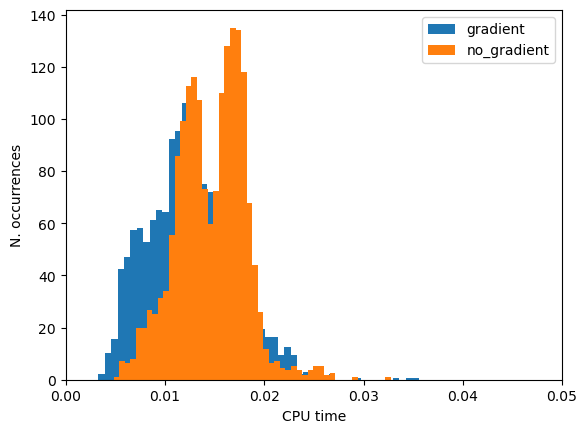

In [9]:
plt.hist(cpu_g, bins=50, label="gradient", density=True)
plt.hist(cpu_nog, bins=50, label="no_gradient", density=True);
plt.xlim([0,0.05])
plt.legend()
np.mean(cpu_g)
plt.xlabel("CPU time")
plt.ylabel("N. occurrences")



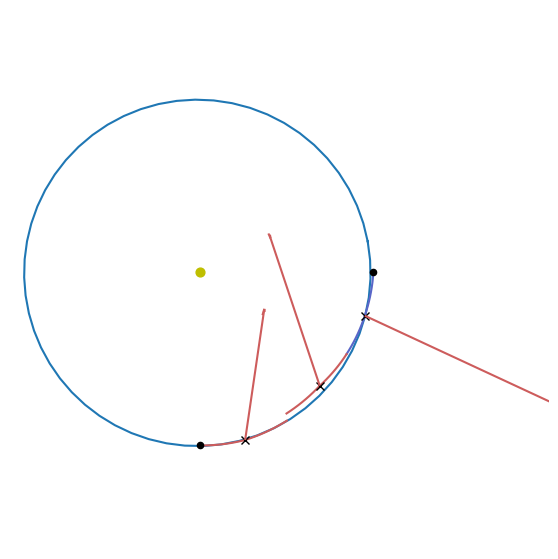

In [8]:
# Making the axis
ax = pk.plot.make_3Daxis(figsize = (7,7))

# Adding the Sun Earth and the boundary states
udpla = pk.udpla.jpl_lp(body="EARTH")
earth = pk.planet(udpla)
pk.plot.add_sun(ax, s=40)
pk.plot.add_planet_orbit(ax, earth)
ax.scatter(rs[0]/pk.AU, rs[1]/pk.AU, rs[2]/pk.AU, c = 'k', s=20)
ax.scatter(rf[0]/pk.AU, rf[1]/pk.AU, rf[2]/pk.AU, c = 'k', s=20)

# Plotting the trajctory leg
udp_nog._set_leg_from_x(pop_nog.champion_x)
sf = udp_nog.leg
ax = pk.plot.add_sf_leg(ax, sf, units=pk.AU, show_throttles=True, length=0.4, show_midpoints=True, arrow_length_ratio=0.1)

# Making the axis nicer
D=1
ax.set_xlim(-D,D)
ax.set_ylim(-D/2,D*3/2)
ax.view_init(90,0)
ax.axis('off');


In [10]:
sf.rvs

[[149597870700.0, 0.0, -0.0], [297.8469183169681, 29784.691831696804, -0.0]]